In [1]:
import tensorflow as tf
import numpy as np
import Functions.dataFrameTools as dataFrameTools
import Functions.processGen as processGen
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
import os
from scipy.spatial.distance import pdist, squareform

from parametricVAE import dVAE, plot_history,freeze_layers_before, unfreeze_all_layers, loadData2, my_loadData2, loadData2, custom_sigmoid_cross_entropy_loss_with_logits



### Fetch datasets

In [2]:
dfn = dataFrameTools.normalizeDF(0).astype('float32')

visual_df =pd.read_csv("../data/clip_sBIKED_reduced.csv", index_col=0)
columns_to_drop = [col for col in visual_df.columns if 'color' in col]
visual_df.drop(columns=columns_to_drop, inplace=True)
boolean_columns = visual_df.select_dtypes(include=['bool']).columns
visual_df[boolean_columns] = visual_df[boolean_columns].astype(int)
visual_df = visual_df.sort_index(axis=1)
visual_df = visual_df.select_dtypes(include=['number'])
constant_columns = [col for col in visual_df.columns if visual_df[col].nunique() == 1]
visual_df = visual_df.drop(columns=constant_columns)

rated_bikes_df = pd.read_csv("processed_ratings.csv")

all_my_bikes_df = visual_df.loc[rated_bikes_df['bid'].unique()]
dfn_all_my_bikes_df = dfn.loc[all_my_bikes_df.index]

average_ratings = rated_bikes_df.groupby('bid')['rating'].mean()
usable_bikes = visual_df.loc[average_ratings[average_ratings > 0.7].index]
unusable_bikes = visual_df.loc[average_ratings[average_ratings < 0.3].index]
meaningfull_bikes_df = pd.concat([usable_bikes, unusable_bikes])
meaningfull_bikes_df['usable'] = meaningfull_bikes_df.index.isin(usable_bikes.index).astype(int)

Loaded Imputed Dataframe in  1.4586365222930908 seconds


### Fetch original VAE

In [3]:
ddims = 2395

# tuned_VAE_name = 'tuned2VAE'
# tunedVAE = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
# tunedVAE.load_weights(f'model weights/{tuned_VAE_name}.h5')
# encoder_tuned = tunedVAE.get_layer('encoder')
# decoder_tuned = tunedVAE.get_layer('decoder')

dataVAE_model =dVAE(ddims, 128, 0.1, 1e-3)
dataVAE_mean = dataVAE_model.build_vae_keras_model_mean()
dataVAE_mean.load_weights('model weights/dataVAE.h5')
encoder_mean =  dataVAE_mean.get_layer('encoder')
decoder_mean =  dataVAE_mean.get_layer('decoder')

all_edited_latent = encoder_mean.predict(dfn_all_my_bikes_df)
all_edited_latent_df = pd.DataFrame(all_edited_latent,index=dfn_all_my_bikes_df.index, columns=[f'Feature_{i}' for i in range(all_edited_latent.shape[1])])

4/4 [==============================] - 1s 3ms/step


# Latent Component Correlation and Mutual Information

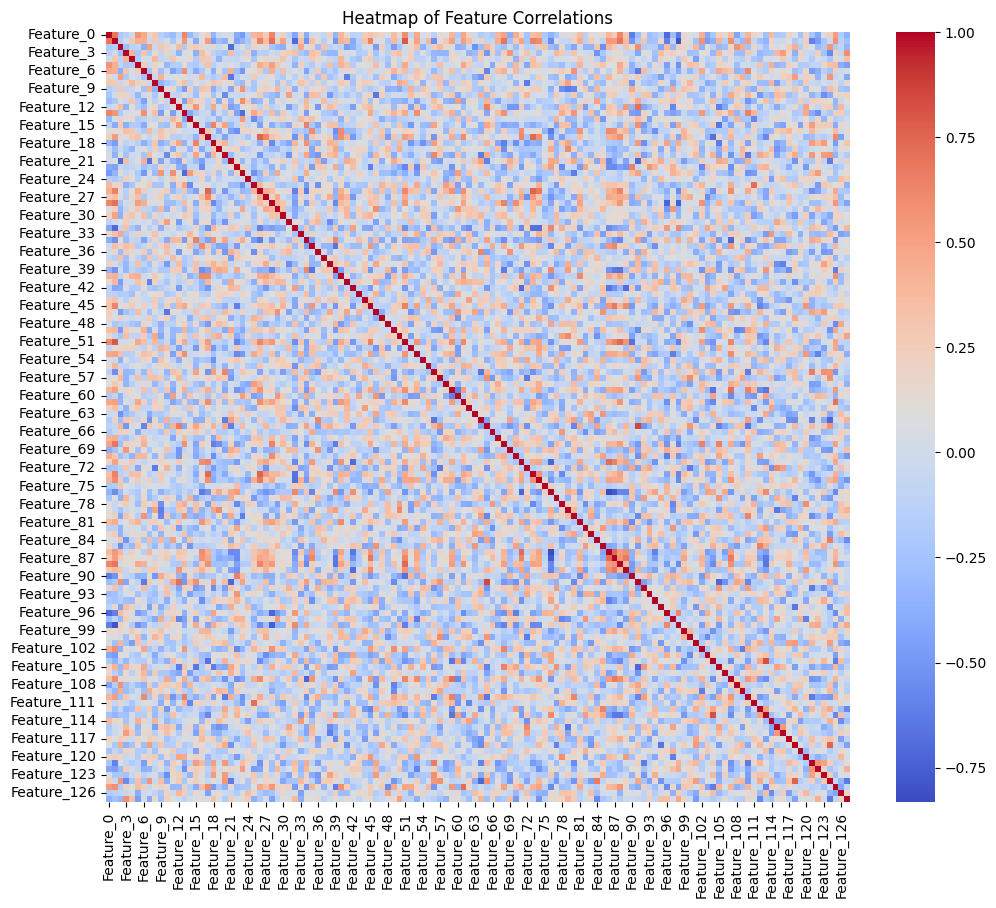

In [29]:
corr = all_edited_latent_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Heatmap of Feature Correlations')
plt.show()

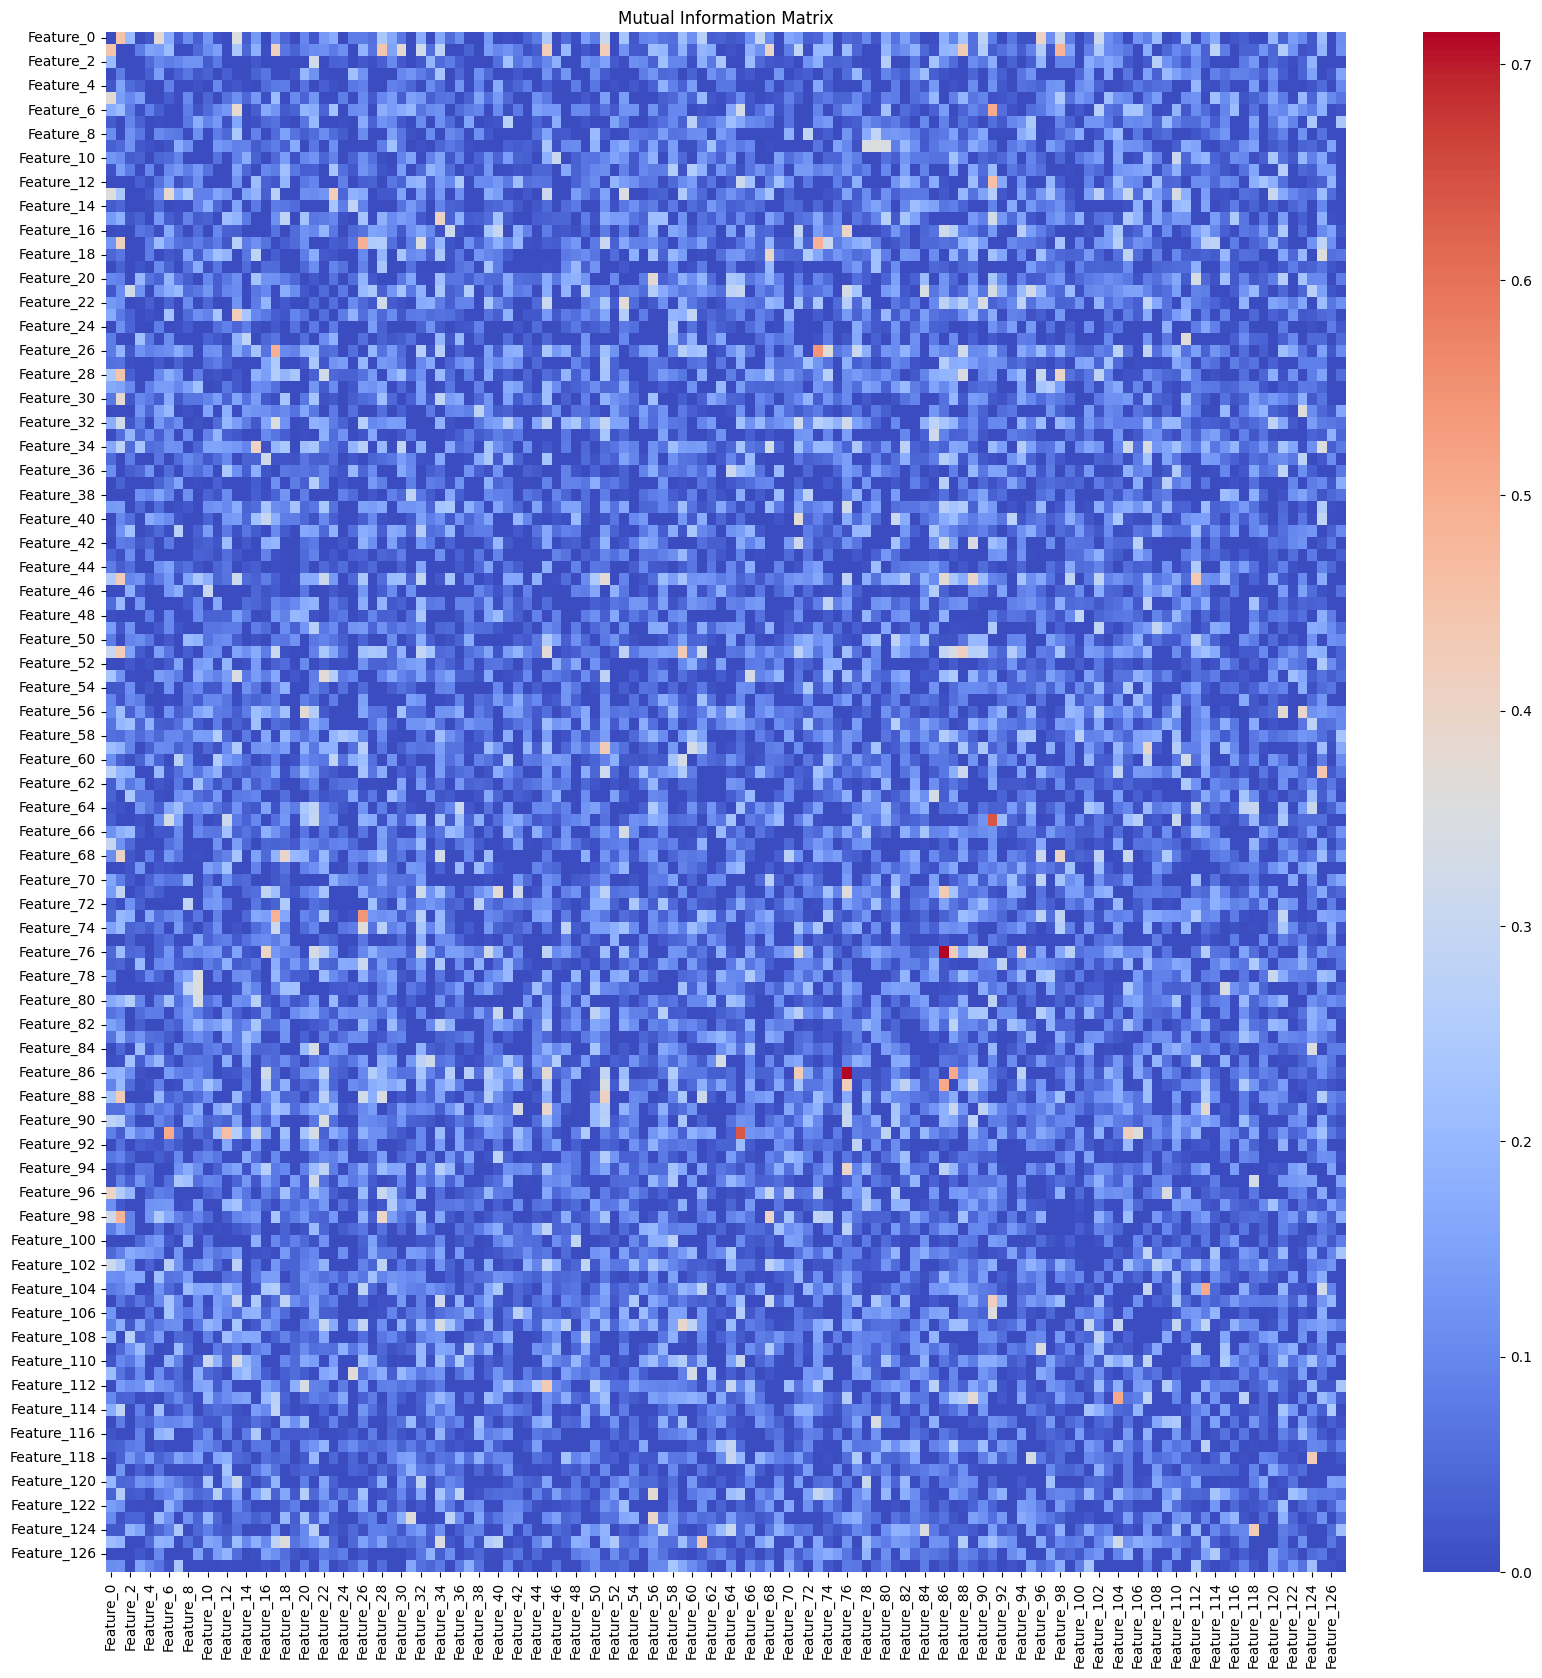

In [30]:
mi_matrix = pd.DataFrame(index=all_edited_latent_df.columns, columns=all_edited_latent_df.columns)

for col_x in all_edited_latent_df.columns:
    for col_y in all_edited_latent_df.columns:
        if col_x != col_y:
            discrete_features = [False]  # Assuming all features are continuous
            mi_matrix.loc[col_x, col_y] = mutual_info_regression(
                all_edited_latent_df[[col_x]], all_edited_latent_df[col_y],
                discrete_features=discrete_features
            )[0]

# Fill diagonal with zeros since mutual information with itself is not relevant
np.fill_diagonal(mi_matrix.values, 0)

mi_matrix = mi_matrix.astype('float')

plt.figure(figsize=(20, 20))
sns.heatmap(mi_matrix, cmap='coolwarm')
plt.title('Mutual Information Matrix')
plt.show()


In [31]:
print(mi_matrix.max().max())

0.7150523085125662


# Inspecting latent components between similar looking bikes

In [4]:
selected_ids = [4330, 4331, 4318, 4416]
selected_df = dfn.loc[selected_ids]
selected_latent = encoder_mean.predict(selected_df)
selected_latent_df = pd.DataFrame(selected_latent,index=selected_ids, columns=[f'Feature_{i}' for i in range(selected_latent.shape[1])])

# #  Regenerate the bikes
# latent = encoder_mean.predict(edited_df)  # Correct prediction using encoder
# res = (tf.math.sigmoid(decoder.predict(latent))).numpy()  # Correct use of decoder
# indexnames = [str(i) for i in edited_ids]
# regen_df = pd.DataFrame(data=res, index=indexnames, columns=dfn.columns)  # Correct DataFrame creation
# regen_df.to_csv("../data/Regen.csv")  # Saving to CSV
# processGen.processGen("Regen", denorm=True)



# # Create and save combined plots with a rug plot for each column
# for column in all_edited_latent_df.columns:
#     os.makedirs(f'Latent Distribution/dataVAE_showing_selected', exist_ok=True)

#     plt.figure(figsize=(10, 6))
    
#     sns.histplot(all_edited_latent_df[column], bins=10, kde=True)
#     sns.rugplot(all_edited_latent_df[column], height=0.1)
    
#     for value in selected_latent_df[column]:
#         plt.axvline(value, color='red', linestyle='--', linewidth=0.8)
    
#     plt.title(f'Distribution of {column}')
#     plt.xlabel('Value')
#     plt.ylabel('Frequency/Density')
#     plt.savefig(f'Latent Distribution/dataVAE_showing_selected/{column}_distribution.png')
#     plt.close()

1/1 [==============================] - 0s 34ms/step


### Similar bikes should have similar component values

In [58]:
max_distance = 0.1
small_range_features = [col for col in selected_latent_df.columns if selected_latent_df[col].max() - selected_latent_df[col].min() <= max_distance]
small_range_features_df = selected_latent_df[small_range_features]

print(f"Components where the difference between the highest and lowest value is <= {max_distance}:")
print(small_range_features)

Components where the difference between the highest and lowest value is <= 0.1:
['Feature_0', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_26', 'Feature_27', 'Feature_28', 'Feature_29', 'Feature_30', 'Feature_31', 'Feature_32', 'Feature_33', 'Feature_34', 'Feature_35', 'Feature_36', 'Feature_37', 'Feature_38', 'Feature_39', 'Feature_40', 'Feature_41', 'Feature_42', 'Feature_43', 'Feature_45', 'Feature_47', 'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 'Feature_52', 'Feature_54', 'Feature_55', 'Feature_56', 'Feature_57', 'Feature_58', 'Feature_59', 'Feature_60', 'Feature_61', 'Feature_62', 'Feature_63', 'Feature_64', 'Feature_65', 'Feature_66', 'Feature_67', 'Feature_68', 'Feature_69', 'Feature_70', 'Feature_71', 'Fea

In [59]:
latent_array = np.array(all_edited_latent_df)
dist_matrix = pdist(latent_array, metric='euclidean')
average_distance = np.mean(dist_matrix)
print(f'all avg {average_distance}')

latent_array = np.array(selected_latent_df)
dist_matrix = pdist(latent_array, metric='euclidean')
print(f'selected {np.mean(dist_matrix)}')

all avg 5.085119327190892
selected 1.8175512178597415


In [6]:

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def find_min_distance(df):
    min_distance = np.inf
    min_distance_ids = (None, None)

    # Loop through all pairs of points to calculate their distances
    for i in range(len(df) - 1):
        for j in range(i + 1, len(df)):
            point1 = df.iloc[i].values
            point2 = df.iloc[j].values
            distance = euclidean_distance(point1, point2)
            
            # Update the minimum distance and IDs if a smaller distance is found
            if distance < min_distance:
                min_distance = distance
                min_distance_ids = (df.index[i], df.index[j])

    return min_distance_ids , min_distance



In [5]:
BIKED_latent = encoder_mean.predict(dfn)
BIKED_latent_df = pd.DataFrame(BIKED_latent,index=dfn.index, columns=[f'Feature_{i}' for i in range(BIKED_latent.shape[1])])
dist_matrix_BIKED = pdist(BIKED_latent_df.values, metric='euclidean')

  1/141 [..............................] - ETA: 2s

141/141 [==============================] - 0s 2ms/step


In [11]:
min_distance_ids_selected,min_distance_selected =  find_min_distance(selected_latent_df)
print(f'Two IDs with the smallest Euclidean distance of selected bikes: {min_distance_ids_selected} with distance {min_distance_selected}')

min_distance_ids_all,min_distance_all =  find_min_distance(all_edited_latent_df)
print(f'Two IDs with the smallest Euclidean distance of all my bikes: {min_distance_ids_all} with distance {min_distance_all}')

dist_matrix_square = squareform(dist_matrix_BIKED)
np.fill_diagonal(dist_matrix_square, np.inf)
min_distance_BIKED = np.min(dist_matrix_square)
min_distance_indices = np.where(dist_matrix_square == min_distance_BIKED)
pairs = list(zip(min_distance_indices[0], min_distance_indices[1]))
index1, index2 = pairs[0]
min_distance_ids_BIKED = (dfn.index[index1],dfn.index[index2])
print(f'Two IDs with the smallest Euclidean distance of BIKED: {min_distance_ids_BIKED} with distance {min_distance_BIKED}')

Two IDs with the smallest Euclidean distance of selected bikes: (4330, 4331) with distance 0.5705344080924988
Two IDs with the smallest Euclidean distance of all my bikes: (4677, 4585) with distance 0.8647477626800537
Two IDs with the smallest Euclidean distance of BIKED: (66, 67) with distance 0.0


### Compare smallest distance found between the 4 similar bikes against distance distribution of BIKED

c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


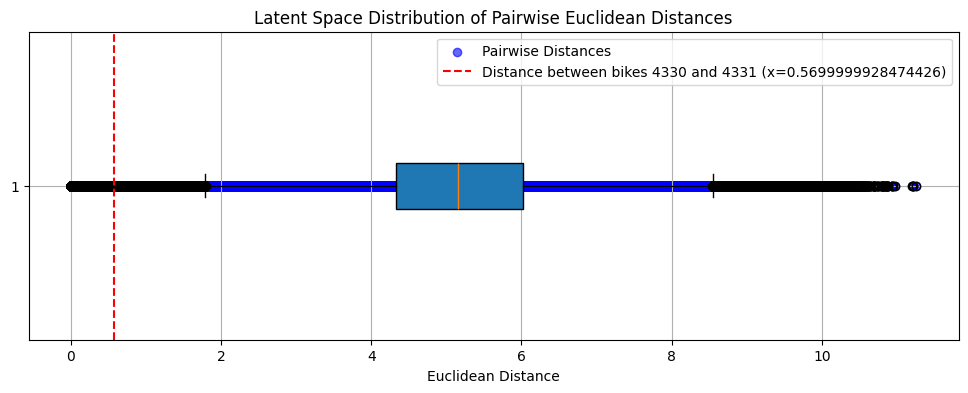

In [12]:


plt.figure(figsize=(12, 4))
plt.boxplot(dist_matrix_BIKED, vert=False, patch_artist=True)

plt.scatter(dist_matrix_BIKED, np.ones_like(dist_matrix_BIKED), alpha=0.6, color='blue', label='Pairwise Distances')

plt.axvline(x=min_distance_selected, color='red', linestyle='--', label=f'Distance between bikes {min_distance_ids_selected[0]} and {min_distance_ids_selected[1]} (x={round(min_distance_selected, 2)})')

plt.xlabel('Euclidean Distance')
plt.title('Latent Space Distribution of Pairwise Euclidean Distances')
plt.legend()
plt.grid(True)
plt.show()

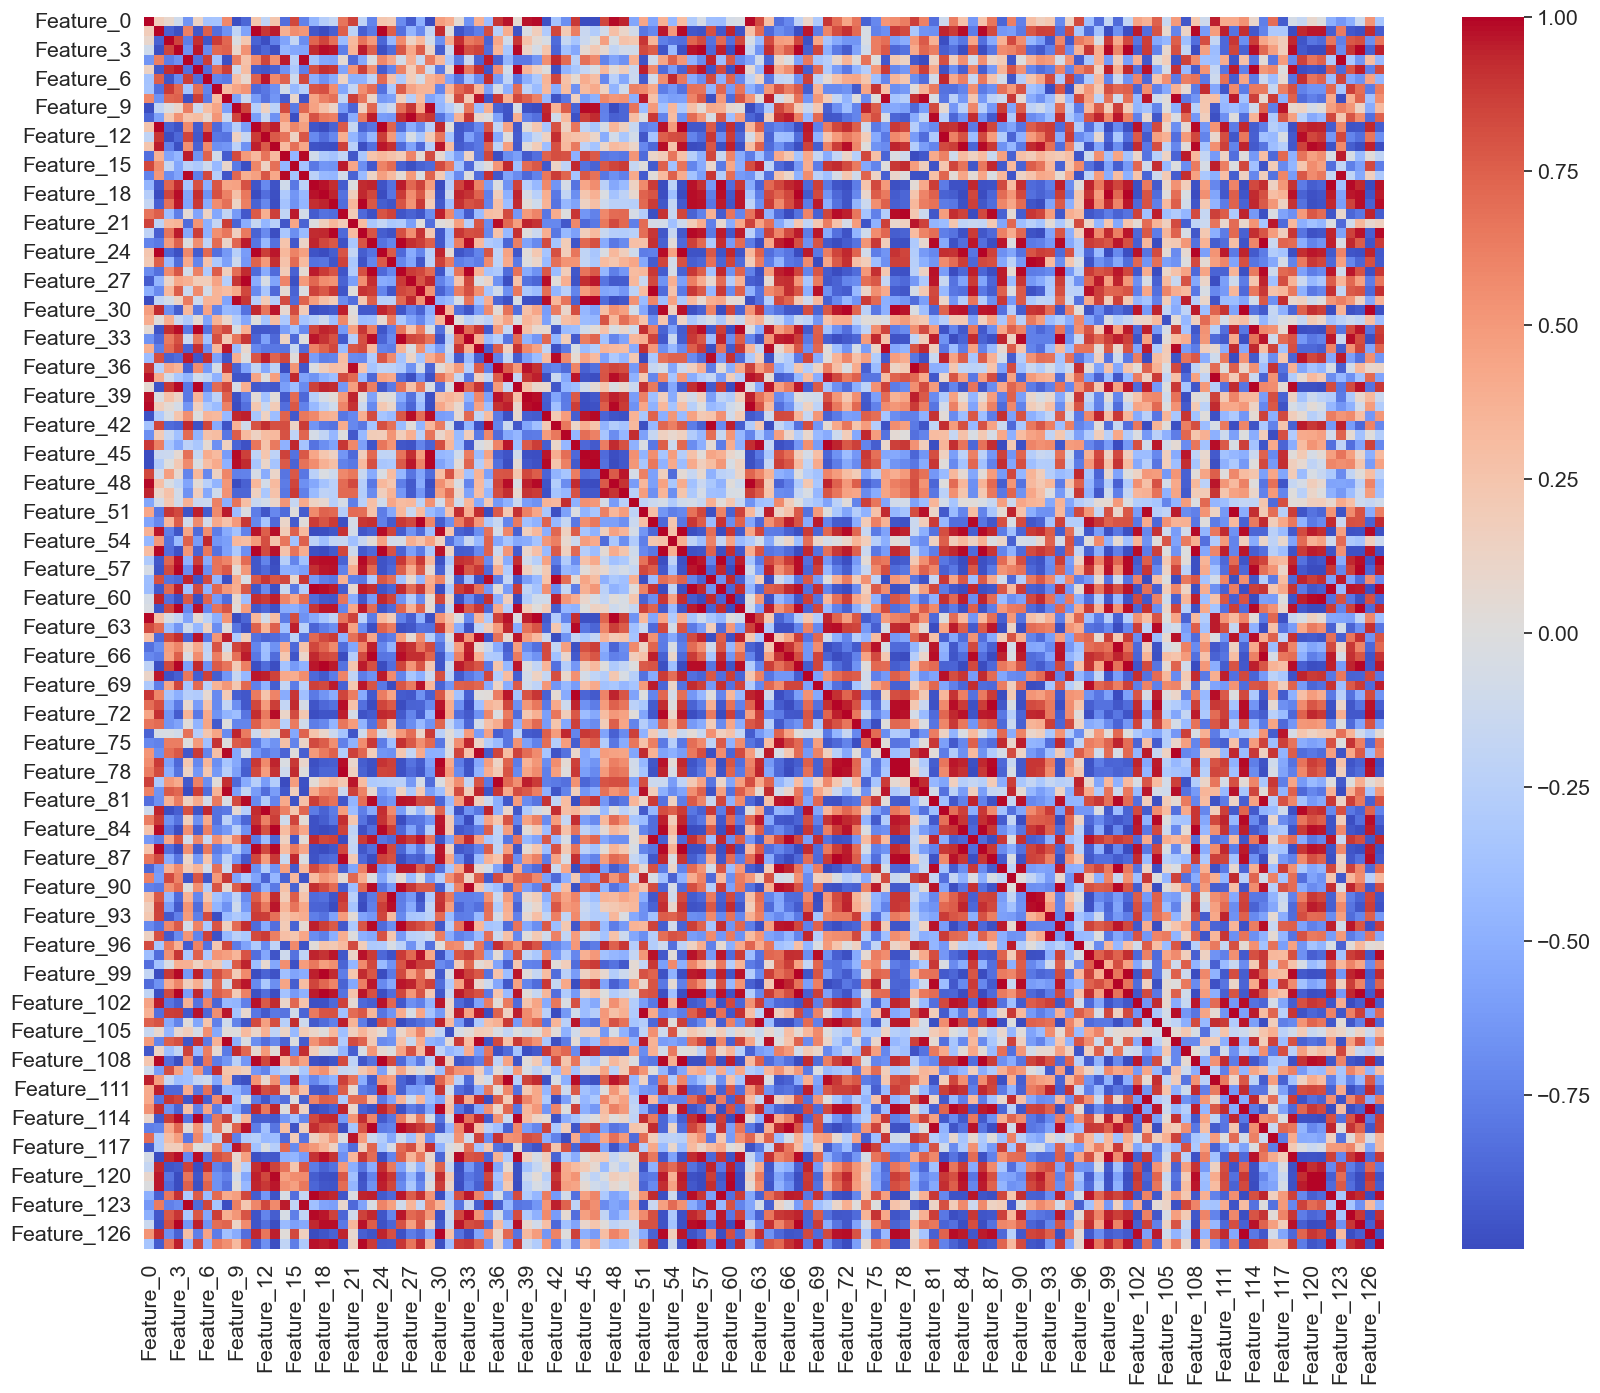

In [13]:

# np.fill_diagonal(mi_matrix.values, 0)
correlation_matrix = selected_latent_df.corr()
sns.set(font_scale=1.4)
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm')
# plt.title('Correlation Matrix')
plt.show()

# Effect of changing a single bike parameter on the latent components

C:\Users\fabie\AppData\Local\Temp\ipykernel_17540\2165922539.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4812529680875687' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample['Saddle height'] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_17540\2165922539.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.48091787055090024' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample['Saddle height'] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_17540\2165922539.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.48058277301423186' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample['Saddle

32/32 [==============================] - 0s 3ms/step


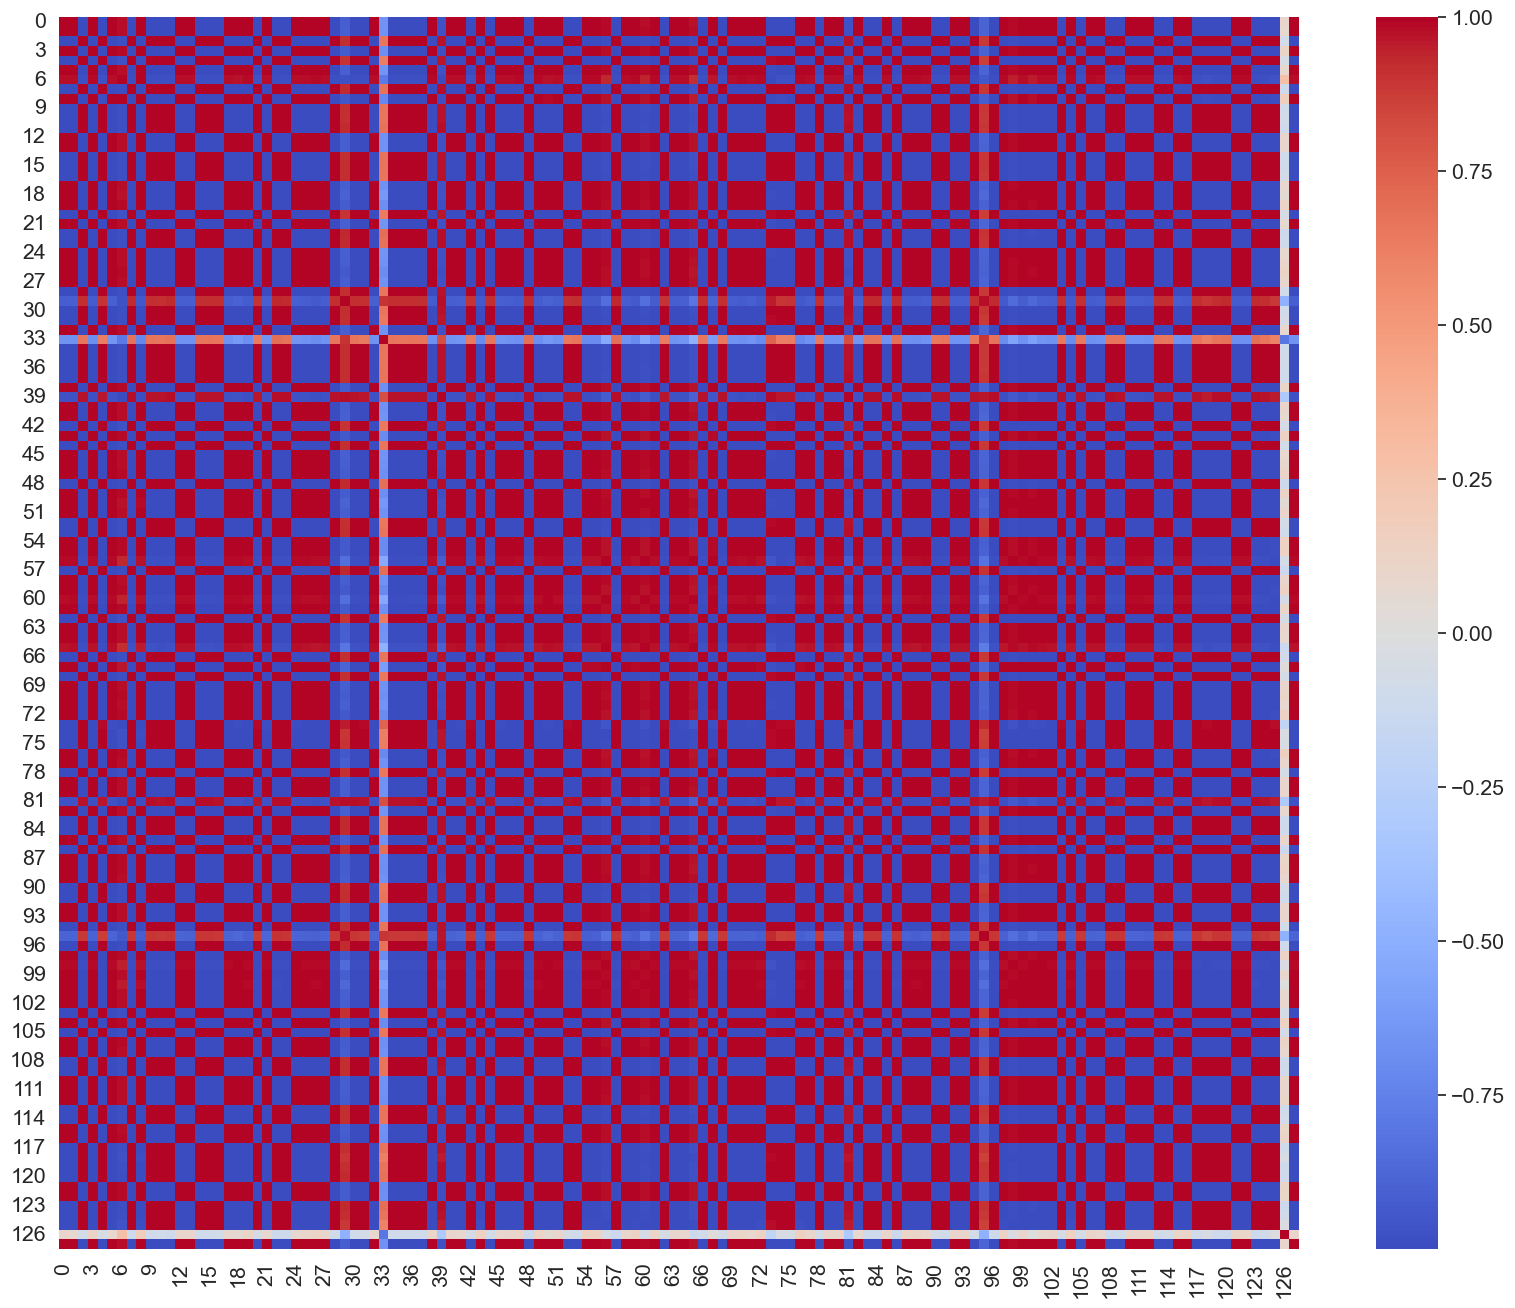

In [48]:
# Fix all parameters except for one. Create samples with varying parameter value from max to min
parameter_name = 'Saddle height'
encoder = encoder_mean
# encoder = tunedVAE.get_layer('encoder')
bike_max_htl = dfn_all_my_bikes_df.loc[dfn_all_my_bikes_df[parameter_name].idxmax()]
# mid_bike = edited_df.loc[1385 ]
divided_space = np.linspace(bike_max_htl[parameter_name], dfn_all_my_bikes_df[parameter_name].min(), 1000)

new_samples = []

for htl in divided_space:
    # sample = all_my_bikes_df.loc[2284 ].copy()
    sample = bike_max_htl.copy()
    sample[parameter_name] = htl
    new_samples.append(sample)

new_df = pd.DataFrame(new_samples)

latent_fixed = encoder.predict(new_df)
latent_fixed_df = pd.DataFrame(latent_fixed, index=new_df.index)

non_constant_columns = latent_fixed_df.loc[:, (latent_fixed_df != latent_fixed_df.iloc[0]).any()].columns
latent_fixed_df = latent_fixed_df[non_constant_columns]

correlation_matrix = latent_fixed_df.corr()

sns.set(font_scale=1.4)
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix')
plt.show()

## PCA to uncover raletionships between components

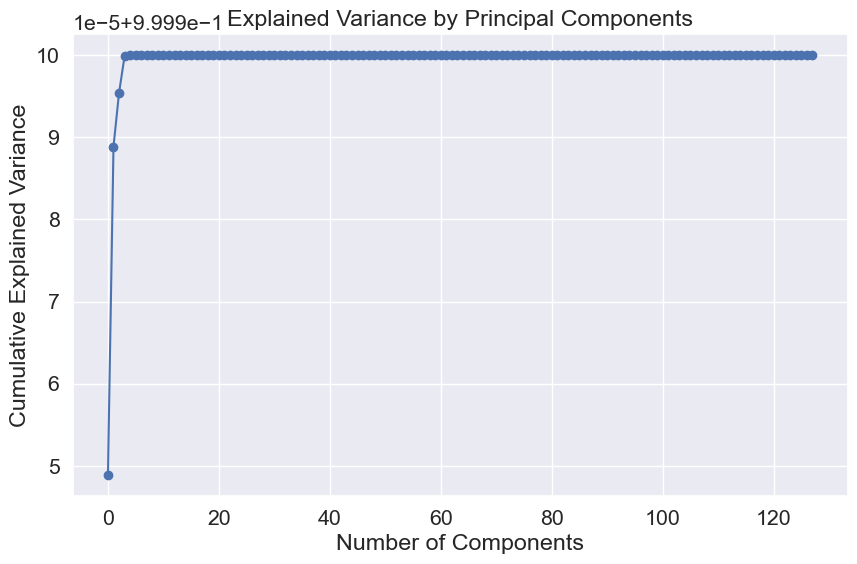

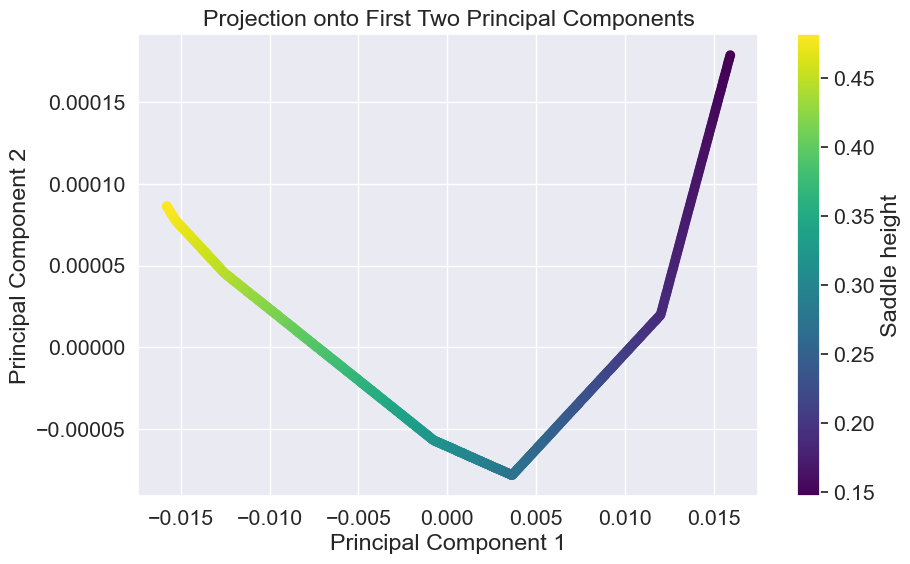

Top 10 features contributing to the first principal component:
Index([124, 25, 46, 91, 79, 113, 78, 16, 1, 15], dtype='int64')


In [49]:
from sklearn.decomposition import PCA

# Assuming latent_fixed_df is already defined

# Perform PCA on the latent representation
pca = PCA()
pca.fit(latent_fixed_df)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance to determine how many components to consider
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Choose the number of components that explain a significant amount of variance (e.g., 95%)
n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.95) + 1

# Ensure that n_components is at least 2 for visualization purposes
n_components = max(n_components, 2)

# Perform PCA again with the chosen number of components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(latent_fixed_df)

# Create a DataFrame with the principal components
principal_components_df = pd.DataFrame(principal_components, index=new_df.index)

# Check the shape of the DataFrame to ensure it has at least two components
if principal_components_df.shape[1] >= 2:
    # Visualize the data in the space of the first two principal components
    plt.figure(figsize=(10, 6))
    plt.scatter(principal_components_df.iloc[:, 0], principal_components_df.iloc[:, 1], c=divided_space, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label=parameter_name)
    plt.title('Projection onto First Two Principal Components')
    plt.grid(True)
    plt.show()
else:
    print("PCA did not produce at least two components.")

# Analyze the principal components to understand the directions of variation
loading_scores = pd.Series(pca.components_[0], index=latent_fixed_df.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
top_features = sorted_loading_scores.index[:10]

print("Top 10 features contributing to the first principal component:")
print(top_features)

In [50]:
# Get the coefficients for PC1
pc1_coefficients = pca.components_[0]

# Display the equation for PC1 (optional)
features = latent_fixed_df.columns
pc1_equation = "PC1 = " + " + ".join(f"{coef:.4f}*{feature}" for coef, feature in zip(pc1_coefficients, features))
print(pc1_equation)

PC1 = -0.0214*0 + -0.0567*1 + 0.0217*2 + -0.0082*3 + 0.0060*4 + -0.0170*5 + -0.0022*6 + 0.0242*7 + -0.0038*8 + 0.0195*9 + 0.0087*10 + 0.0132*11 + -0.0020*12 + -0.0314*13 + 0.0132*14 + 0.0372*15 + 0.1428*16 + -0.0069*17 + -0.0076*18 + -0.0152*19 + 0.0072*20 + -0.0123*21 + 0.0139*22 + 0.0186*23 + -0.0066*24 + -0.4359*25 + -0.0183*26 + -0.0037*27 + 0.0107*28 + 0.0010*29 + 0.0121*30 + 0.0024*31 + -0.0045*32 + 0.0002*33 + 0.0176*34 + 0.0169*35 + 0.0274*36 + 0.0142*37 + -0.0193*38 + 0.0015*39 + -0.0242*40 + -0.0125*41 + 0.0100*42 + -0.0078*43 + 0.0087*44 + -0.0170*45 + -0.3739*46 + -0.0069*47 + 0.0088*48 + -0.0094*49 + -0.0024*50 + -0.0143*51 + 0.0158*52 + 0.0084*53 + -0.0056*54 + -0.0073*55 + -0.0043*56 + 0.0104*57 + -0.0161*58 + -0.0030*59 + -0.0007*60 + -0.0126*61 + 0.0098*62 + -0.0255*63 + -0.0091*64 + -0.0017*65 + 0.0156*66 + -0.0052*67 + 0.0048*68 + -0.0095*69 + -0.0113*70 + -0.0146*71 + -0.0059*72 + 0.0044*73 + 0.0091*74 + 0.0114*75 + -0.0042*76 + -0.0020*77 + 0.1853*78 + -0.3392*79 +

In [136]:
# 2284: [113, 91, 16, 79, 46, 124, 127, 40, 75, 25]

In [138]:
# bike 1127: [16, 25, 91, 46, 79, 78, 113, 124, 1, 110]
# bike 4255 : [16, 78, 113, 1, 46, 79, 91, 25, 124, 4 ]
#  same for 9 out of 10

In [139]:
# 1127
# 21
# 4782

# Using PCA to change a specific bike parameter from the latent space

In [34]:
latent = encoder_mean.predict(dfn_all_my_bikes_df)
distances = pdist(latent, metric='euclidean')
distance_matrix = squareform(distances)
average_distances = np.mean(distance_matrix, axis=1)
sorted_indices = np.argsort(average_distances)
second_middle_index = sorted_indices[0]
second_middle_id = dfn_all_my_bikes_df.index[second_middle_index]

print(f"The bike that is the most central is {second_middle_id} with an average distance of {average_distances[second_middle_index]}")

# print(f"The bike that is the third most central is {second_middle_id} with an average distance of {average_distances[second_middle_index]}")


4/4 [==============================] - 0s 3ms/step
The bike that is the most central is 999 with an average distance of 4.027465765734629


In [62]:
parameter = 'Saddle length'

mid_bike = dfn_all_my_bikes_df.loc[second_middle_id]

# bike_max_htl = dfn_all_my_bikes_df.loc[dfn_all_my_bikes_df[parameter].idxmax()]
divided_space = np.linspace(dfn_all_my_bikes_df[parameter].max(), dfn_all_my_bikes_df[parameter].min(), 10000)

# bike_max_htl = dfn_all_my_bikes_df.loc[dfn_all_my_bikes_df[parameter].idxmax()]
# head_tube_lengths = np.linspace(bike_max_htl[parameter], dfn_all_my_bikes_df[parameter].min(), 10000)

new_samples = []
for htl in divided_space:
    sample = mid_bike.copy()
    sample[parameter] = htl
    new_samples.append(sample)

new_df = pd.DataFrame(new_samples)
latent_fixed = encoder_mean.predict(new_df)
latent_fixed_df = pd.DataFrame(latent_fixed, index=new_df.index)

non_constant_columns = latent_fixed_df.loc[:, (latent_fixed_df != latent_fixed_df.iloc[0]).any()].columns
latent_fixed_df = latent_fixed_df[non_constant_columns]

pca = PCA()
principal_components = pca.fit_transform(latent_fixed_df)
principal_components_df = pd.DataFrame(principal_components, index=new_df.index)

correlation = np.corrcoef(principal_components_df.iloc[:, 0], divided_space)[0, 1]
if correlation > 0:
    gradient = pc1_coefficients
    print(f"The gradient of PC1 points towards increasing values of {parameter}.")
else:
    gradient = - pc1_coefficients
    print(f"The gradient of PC1 points towards decreasing values of {parameter}.")
    
def move_to_reduce_saddle_height_PCA(latent_point,gradient, step_size=0.1):
    return latent_point - step_size * gradient


C:\Users\fabie\AppData\Local\Temp\ipykernel_17540\1397875499.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2399874219503423' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[parameter] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_17540\1397875499.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.23997484926510268' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[parameter] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_17540\1397875499.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.23996227657986302' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[parameter] = htl
C:

313/313 [==============================] - 1s 3ms/step
The gradient of PC1 points towards decreasing values of saddle height.


In [65]:
# max_id = edited_df['Saddle height'].idxmax()
# bike = edited_df.loc[[4474]]
# latent = encoder_mean.predict(bike)
encoder = encoder_mean
decoder = decoder_mean
bike = dfn_all_my_bikes_df.iloc[[99]]   # Pick any bike

latent = encoder.predict(bike)
indices = [f'{bike.index}saddle{i}' for i in range(4)]
given_point = latent[0]  

new_points = [given_point]
for i in range(1,4):
    new_point = move_to_reduce_saddle_height_PCA(given_point, i*0.6)
    new_points.append(new_point)

new_point_array = np.array(new_points)

res=(tf.math.sigmoid(decoder.predict(new_point_array))).numpy()
meandf=pd.DataFrame(res, index=indices, columns=dfn.columns)
meandf.to_csv("../data/saddle.csv")  # Saving to CSV
saddle_df = processGen.processGen("saddle", denorm=True)
saddle_df['Saddle height']

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step
Loaded Imputed Dataframe in  1.473902940750122 seconds
1.0 fraction valid


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

One-hot encoding 106 features
Onehot Completed in 0.4498560428619385 seconds
Loaded Imputed Dataframe in  1.2836616039276123 seconds


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

Index([2475], dtype='int64')saddle0    696.450137
Index([2475], dtype='int64')saddle1    695.529589
Index([2475], dtype='int64')saddle2    694.962794
Index([2475], dtype='int64')saddle3    694.519309
Name: Saddle height, dtype: float64

In [54]:
# saddle_heights = new_samples_df[parameter].values

# # Fit a regression model
# reg_model = LinearRegression()
# reg_model.fit(latent_new, saddle_heights)

# def move_to_reduce_saddle_height(latent_point, reg_model, step_size=0.1, target_saddle_height=None):
#     # current_saddle_height = reg_model.predict([latent_point])[0]
#     # if target_saddle_height is None:
#     #     target_saddle_height = current_saddle_height - step_size
    
#     gradient = reg_model.coef_
    
#     # adjustment_factor = (current_saddle_height - target_saddle_height) / np.linalg.norm(gradient)
#     # adjusted_step_size = step_size * adjustment_factor
    
#     # Move the point in the opposite direction of the gradient
#     # new_point = latent_point + adjusted_step_size * gradient
#     new_point = latent_point - step_size * gradient
    
#     return new_point

# # # Example usage
# # given_point = latent_new[0]  # Example point in the latent space
# # new_point = move_to_reduce_saddle_height(given_point, reg_model)
# # new_point_array = np.array([new_point])

# # print(f"Original point: {given_point}")
# # print(f"New point (array of arrays): {new_point_array}")

# # # Example of reducing saddle height for multiple points
# # given_points = latent_new[:5]  # Example points in the latent space

# # new_points = []
# # for point in given_points:
# #     new_point = move_to_reduce_saddle_height(point, reg_model)
# #     new_points.append(new_point)

# # new_points_array = np.array(new_points)

# # print(f"Original points: {given_points}")
# # print(f"New points (array of arrays): {new_points_array}")

In [ ]:
# latent = encoder_mean.predict(edited_df)
# id_487_index = edited_df.index.get_loc(4474 )
# distances = pdist(latent, metric='euclidean')
# distance_matrix = squareform(distances)
# distances_from_id_487 = distance_matrix[id_487_index]
# furthest_index = np.argmax(distances_from_id_487)
# furthest_id = edited_df.index[furthest_index]
# print(f"The ID that is furthest away from ID 4474 is {furthest_id} with a distance of {distances_from_id_487[furthest_index]}")


5/5 [==============================] - 0s 2ms/step
The ID that is furthest away from ID 4474 is 2284 with a distance of 8.428228151435231


In [ ]:
# edited_df['Saddle height'].idxmin()

3210

In [ ]:
# mean_saddle_length = edited_df[parameter].mean()
# edited_df['difference'] = np.abs(edited_df[parameter] - mean_saddle_length)
# closest_bike_index = edited_df['difference'].idxmin()
# closest_bike = edited_df.loc[closest_bike_index]
# edited_df.drop(columns=['difference'], inplace=True)
# print(closest_bike)

SSSIDECX3                               0.099401
SSSIDECX2                               0.242904
SSSIDECX1                               0.269076
SSSIDECY2                               0.173913
SSSIDECY1                               0.295455
                                          ...   
bottle SEATTUBE0 show OHCLASS: False    1.000000
bottle SEATTUBE0 show OHCLASS: True     0.000000
bottle DOWNTUBE0 show OHCLASS: False    0.000000
bottle DOWNTUBE0 show OHCLASS: True     1.000000
Saddle length difference                0.001083
Name: 2100, Length: 2396, dtype: float32


In [ ]:
# 4474
# 2284 
# 487